In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae

C:\Users\AURIMASSilva\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('fourGreta.csv')
data = df['price'].values

In [3]:
sc = MinMaxScaler(feature_range=(0,1))
sc.fit(data.reshape(-1,1))
data = sc.transform(data.reshape(-1,1))
data = data.reshape(1,-1)[0]

In [4]:
data_gen = TimeseriesGenerator(np.append(data,0.00), np.append(data,0.00),
                                       length= 10, sampling_rate=1,
                                       batch_size=1)

# get features and targets from generated batches
features = []
targets = []
i = 0
while True:
    try:
        features.append(list(data_gen[i][0][0]))
        targets.append(data_gen[i][1][0])
        i += 1
    except:
        break
        
        
# convert to numpy arrays for further use
features = np.array(features)
targets = np.array(targets)



# get the training, validation and testing sets
x_test, y_test = features[-32:], targets[-32:]
x_hold, y_hold = features[:-32], targets[:-32]



x_train, x_valid = x_hold[:int(len(x_hold)*.9)], x_hold[int(len(x_hold)*.9):]
y_train, y_valid = y_hold[:int(len(y_hold)*.9)], y_hold[int(len(y_hold)*.9):]

assert len(x_train) + len(x_valid) == len(x_hold)
assert len(y_train) + len(y_valid) == len(y_hold)

In [5]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_valid = x_valid.reshape(x_valid.shape[0],x_valid.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

In [7]:
model = Sequential()
model.add(LSTM(100,  input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1, activation = 'linear'))
print('GRU Model Summary')
model.summary()

GRU Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [8]:
# optimizer
optim = Adam(lr = 0.005)

In [9]:
model.compile(loss='mse', optimizer=optim, metrics=['mse'])

In [10]:
filepath = "C:\\Users\\AURIMASSilva\\Desktop\\BTC\\memes\\model123.hdf5"
checkpoint = [
    ModelCheckpoint(filepath, monitor = 'val_mean_squared_error', verbose =1, save_best_only=True, mode= 'min')]
#callbacks_list = [checkpoint]                           



model.fit(x_train, y_train, batch_size = 1, epochs = 20, validation_data =(x_valid, y_valid), verbose = 2, callbacks = checkpoint)

Train on 1363 samples, validate on 152 samples
Epoch 1/20
 - 11s - loss: 2.0526e-04 - mean_squared_error: 2.0526e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021

Epoch 00001: val_mean_squared_error improved from inf to 0.00205, saving model to C:\Users\AURIMASSilva\Desktop\BTC\memes\model123.hdf5
Epoch 2/20
 - 11s - loss: 4.8946e-05 - mean_squared_error: 4.8946e-05 - val_loss: 0.0017 - val_mean_squared_error: 0.0017

Epoch 00002: val_mean_squared_error improved from 0.00205 to 0.00174, saving model to C:\Users\AURIMASSilva\Desktop\BTC\memes\model123.hdf5
Epoch 3/20
 - 11s - loss: 4.1292e-05 - mean_squared_error: 4.1292e-05 - val_loss: 0.0019 - val_mean_squared_error: 0.0019

Epoch 00003: val_mean_squared_error did not improve
Epoch 4/20
 - 10s - loss: 5.6427e-05 - mean_squared_error: 5.6427e-05 - val_loss: 0.0019 - val_mean_squared_error: 0.0019

Epoch 00004: val_mean_squared_error did not improve
Epoch 5/20
 - 10s - loss: 4.0565e-05 - mean_squared_error: 4.0565e-05 - val_loss:

KeyboardInterrupt: 

In [11]:
y_hat = model.predict(x_test)
y_test_true = sc.inverse_transform(y_test.reshape(-1,1))
y_hat_true = sc.inverse_transform(y_hat.reshape(-1,1))
np.sqrt(mse(y_test_true, y_hat_true))


378.1681229769117

In [12]:
mae(y_test_true, y_hat_true)

305.11475524902346

In [13]:
np.sum(y_test_true - y_hat_true)/len(y_test_true)

123.04154846191403

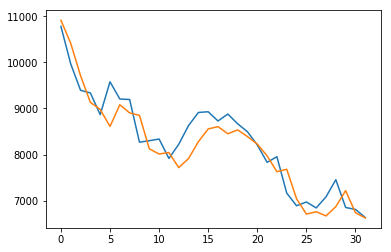

In [14]:
plt.plot(y_test_true)
plt.plot(y_hat_true)
plt.show()